# CSC321 Tutorial 6: Optimization and Convolutional Neural Networks

In lecture 5, we talk about different issues that may arise when 
training an artificial neural network. Today, we'll explore some of these
issues, and explore different ways that we can optimize a neural network's
cost function.

In lecture 6, we will cover convolutional neural networks. Since this is
the last tutorial before reading week, we will also train some CNN's today.
If you are in the Tuesday lecture section, don't worry! Think of CNN's as a
neural network with a slightly different architecture, or that the weights
are "wired" differently. These weights (parameters) still can be optimized
via gradient descent, and we will still use the back-propagation algorithm.

Please note that because there is stochasticity in the way we initalize the
neural network weights, so we will get different results (final training/validation
accuracies) if we run the initialization + training multiple times.
You will need to run some of the provided code multiple times to make
a conclusion about what optimization methods work well.

In [3]:
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

## Data

We'll use the MNIST data set, the same data set that we introduced in
Tutorial 4.
The MNIST dataset contains black and white, hand-written (numerical) digits
that are 28x28 pixels large.
As in tutorial 4, we'll only use the first 2500 images in the MNIST dataset.
The first time you run this code, we will download the MNIST dataset.

In [2]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST('data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
mnist_train = list(mnist_train)[:2500]

mnist_train, mnist_val = mnist_train[:2000], mnist_train[2000:]

9920512it [00:03, 3045197.10it/s]                                                                                      


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz


32768it [00:00, 260993.57it/s]                                                                                         


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz


1654784it [00:01, 1410458.45it/s]                                                                                      


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz


8192it [00:00, 93088.07it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


## Models in PyTorch

We'll work with two models: a MLP and a convolutional neural network.

In [5]:
# Multi-layer perceptron
class MLP(nn.Module):
    def __init__(self, num_hidden):
        super(MLP, self).__init__() # inherit from neural net module in pytorch
        self.layer1 = nn.Linear(28 * 28, num_hidden) 
        self.layer2 = nn.Linear(num_hidden, 10)
        self.num_hidden = num_hidden
    def forward(self, img):
        flattened = img.view(-1, 28 * 28) # flatten the image
        activation1 = self.layer1(flattened)
        activation1 = torch.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

# You should understand this after Lecture 6
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, # b/c grayscale img
                               out_channels=4, # we are extracting 4 features using the kernel
                               kernel_size=3,
                               padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=4, # input from the last layer (conv1)
                               out_channels=8, # output 8 features
                               kernel_size=3,
                               padding=1)
        self.fc = nn.Linear(8 * 7 * 7, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # first input
        x = self.pool(torch.relu(self.conv2(x))) # second input
        # max pooling
        x = x.view(-1, 8 * 7 * 7) # build that x as one large vector
        return self.fc(x) # feed it to the fully connected layer

One way to gauge the "complexity" or the "capacity" of the
neural network is by looking at the number of parameters that it
has.

In [6]:
def print_num_parameters(model, name="model"):
    print("Number of parameters in %s" % name,
          sum(p.numel() for p in model.parameters()))

print_num_parameters(MLP(200), "MLP(200)")
print_num_parameters(CNN(), "the CNN")

Number of parameters in MLP(200) 159010
Number of parameters in the CNN 4266


## Training the neural network

We'll use a fairly configurable training training function that computes
both training and validation accuracy in each iteration. This is more

In [8]:
# training process of a nn

def train(model, data, batch_size=64, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9,
          data_shuffle=True, num_epochs=10):
    # training data
    train_loader = torch.utils.data.DataLoader(data,
                                               batch_size=batch_size,
                                               shuffle=data_shuffle)
    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # track learning curve
    iters, losses, train_acc, val_acc = [], [], [], []
    # training
    n = 0 # the number of iterations (for plotting)
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            if imgs.size()[0] < batch_size:
                continue

            model.train() # annotate model for training
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

And of course, we need the `get_accuracy` helper function. To turn the probabilities
into a discrete prediction, we will take the digit with the highest probability.
Because of the way softmax is computed, the digit with the highest probability is
the same as the digit with the (pre-activation) output value.

In [9]:
def get_accuracy(model, train=False):
    if train:
        data = torch.utils.data.DataLoader(mnist_train, batch_size=4096)
    else:
        data = torch.utils.data.DataLoader(mnist_val, batch_size=1024)

    model.eval() # annotate model for evaluation
    correct = 0
    total = 0
    for imgs, labels in data:
        output = model(imgs) # We don't need to run torch.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Let's see what the training curve of a multi-layer perceptron looks like.
This code will take a couple minutes to run...

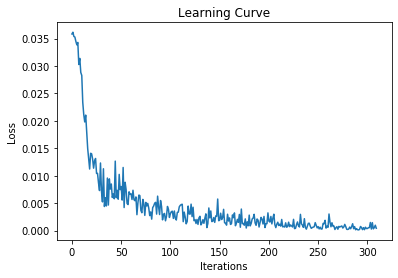

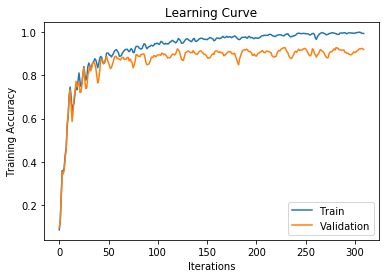

Final Training Accuracy: 0.993
Final Validation Accuracy: 0.918


In [10]:
model = MLP(50)
train(model, mnist_train, learning_rate=0.1)

## MLP Hidden Unit Size

The first thing we'll explore is the hidden unit size. If we increase the number
of hidden units in a MLP, we'll increase its parameters counts.

In [11]:
print_num_parameters(MLP(50), "MLP with 50 hidden units")
print_num_parameters(MLP(100), "MLP with 100 hidden units")
print_num_parameters(MLP(200), "MLP with 200 hidden units")

Number of parameters in MLP with 50 hidden units 39760
Number of parameters in MLP with 100 hidden units 79510
Number of parameters in MLP with 200 hidden units 159010


With more hidden units, our model has more "capacity", and can learn
more intricate patterns in the training data. Our training accuracy will
therefore be higher. However, the computation time for training and
using these networks will also increase.

Adding more parameters tend to widen the gap between training and validation
accuracy. As we add too many parameters, we could overfit. However, we won't
show that here since the computations will take a long time.

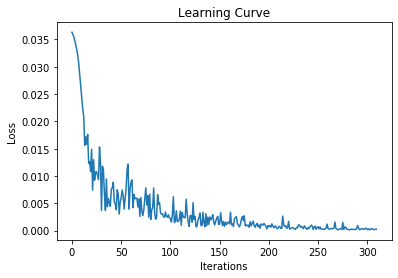

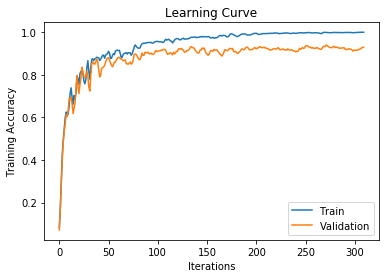

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.93


In [12]:
model = MLP(100)
train(model, mnist_train, learning_rate=0.1)

A smaller network will train faster, but may have worse training accuracy.
Bear in mind that since the neural networks initialization is random, k/

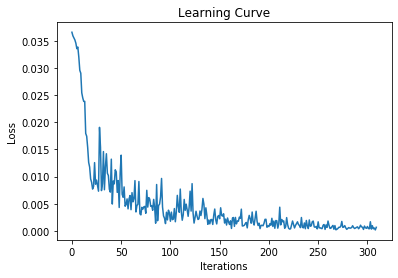

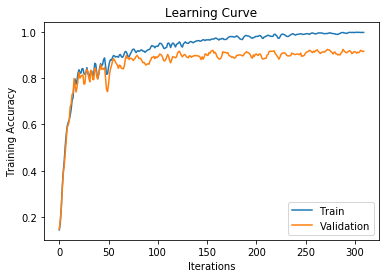

Final Training Accuracy: 0.997
Final Validation Accuracy: 0.916


In [13]:
model = MLP(30)
train(model, mnist_train, learning_rate=0.1)

### Interlude: shuffling the dataset

What if don't off `data_shuffle`? That is, what if we use the **same mini-batches**
across all of our epochs? Can you explain what's going on in this learning
curve?

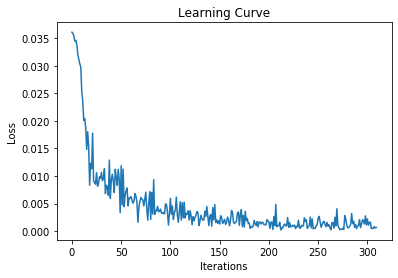

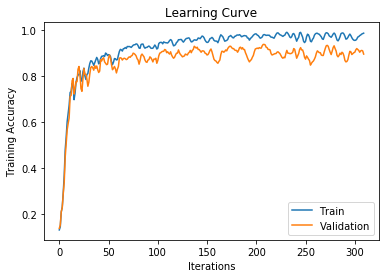

Final Training Accuracy: 0.987
Final Validation Accuracy: 0.896


In [14]:
model = MLP(30)
train(model, mnist_train, learning_rate=0.1, data_shuffle=False)

### Conv Net

The learning curve for the convolutional network looks similar. This network
is a lot more compact with much fewer parameters. The computation time is
a bit longer than training MLPs, but we get fairly good results.
(The learning rate of 0.1 looks a little high for this CNN, based on the noisiness
of the learning curves.)

Number of parameters in the CNN 4266


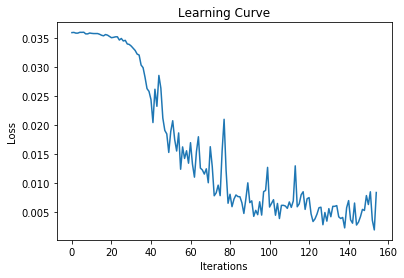

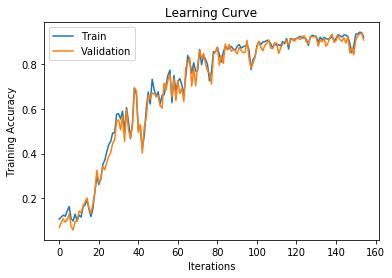

Final Training Accuracy: 0.919
Final Validation Accuracy: 0.906


In [15]:
model = CNN()
print_num_parameters(model, "the CNN")
train(model, mnist_train, batch_size=64, optimizer="sgd", learning_rate=0.1,
      momentum=0., num_epochs=5)

## Momentum

We'll mainly experiment with the `MLP(30)` model, since it trains the fastest.
We'll measure how quickly the model trains by looking at how far we get in 
first 3 epochs of training. Here's how far our model gets without using momenutm,
with a learning rate of 0.1.

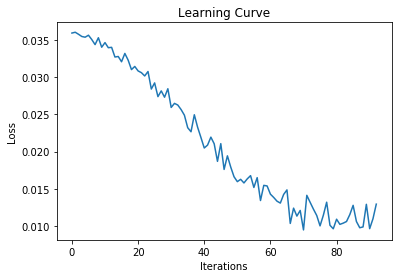

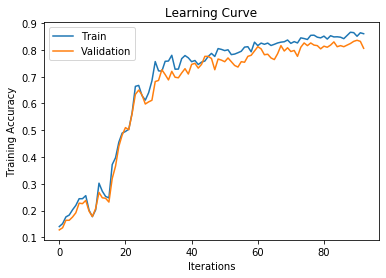

Final Training Accuracy: 0.8605
Final Validation Accuracy: 0.806


In [16]:
model = MLP(30)
train(model, mnist_train, learning_rate=0.1, momentum=0., num_epochs=3)

With a well-tuned learning-rate and momentum parameter, our training can go faster.
(Note: We had to try a few settings before finding one that worked well, and encourage
you to try different combinations of the learning rate and momentum. For example,
learning rate of 0.1 and momentum of

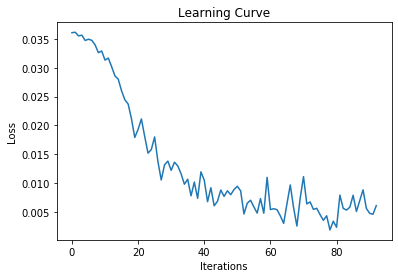

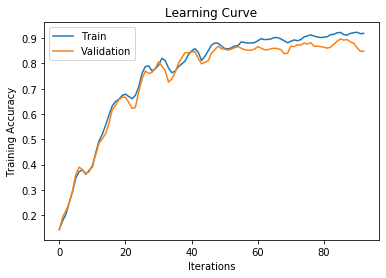

Final Training Accuracy: 0.9185
Final Validation Accuracy: 0.848


In [17]:
model = MLP(30)
train(model, mnist_train, learning_rate=0.05, momentum=0.9, num_epochs=3)

The optimizer Adam works well and is the most popular optimizer nowadays.
Adam typically requires a smaller learning rate: start at 0.001, then increase/decrease
as you see fit. For this example, 0.005 works well.

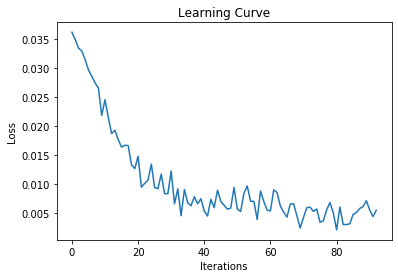

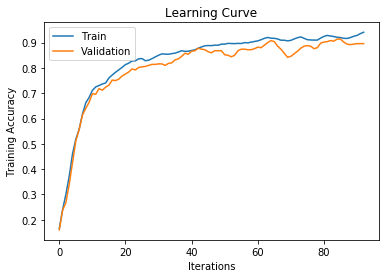

Final Training Accuracy: 0.941
Final Validation Accuracy: 0.896


In [18]:
model = MLP(30)
train(model, mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=3)

Convnets can also be trained using SGD with momentum or with Adam. In particular, our
CNN generalizes very well. (Since our validation accuracy is about equal to our
training accuracy, we can afford to increase the model capacity if we want to.)

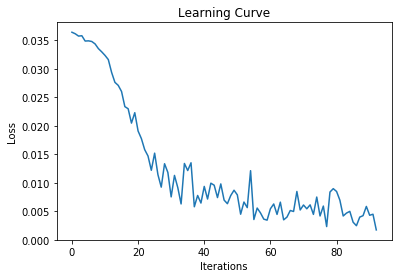

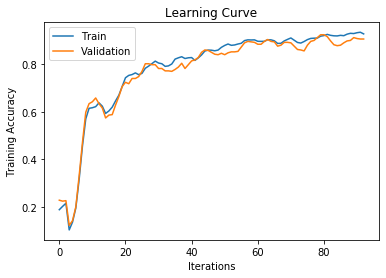

Final Training Accuracy: 0.9275
Final Validation Accuracy: 0.906


In [19]:
model = CNN()
train(model, mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=3)

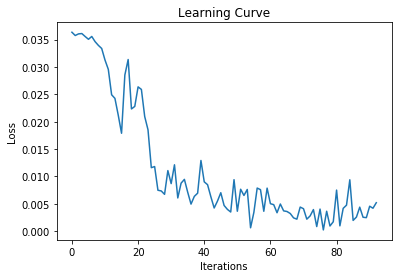

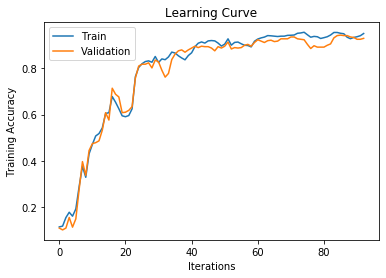

Final Training Accuracy: 0.951
Final Validation Accuracy: 0.93


In [20]:
# Uncomment to run
train(CNN(), mnist_train, learning_rate=0.1, momentum=0.9, num_epochs=3)

## Batch Normalization

Batch normalization speeds up training significantly!

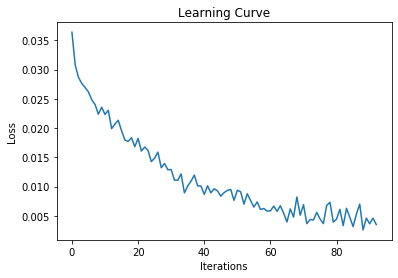

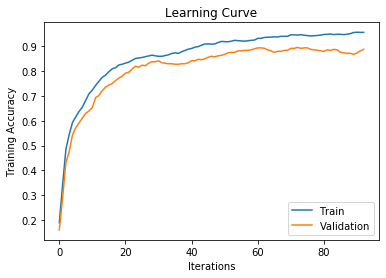

Final Training Accuracy: 0.9565
Final Validation Accuracy: 0.888


In [21]:
class MLPBN(nn.Module):
    def __init__(self, num_hidden):
        super(MLPBN, self).__init__()
        self.layer1 = nn.Linear(28 * 28, num_hidden)
        self.bn = nn.BatchNorm1d(num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        self.num_hidden = num_hidden
    def forward(self, img):
        flattened = img.view(-1, 28 * 28) # flatten the image
        activation1 = self.layer1(flattened)
        activation1 = torch.relu(activation1)
        activation1 = self.bn(activation1)
        activation2 = self.layer2(activation1)
        return activation2

mlp_bn = MLPBN(30)
train(mlp_bn, mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=3)

There is a debate as to whether the batch-normalization should be applied
*before* or *after* the activation. The original batch normalization paper
applied the normalization before the ReLU activation, but applying normalization
*after* the ReLU performs better in practice. 

I (Lisa) believe the reason to be as follows:

1. If we apply normalization before ReLU, then we are effectively ignoring the
   bias parameter of those units, since those unit's activations gets centered
   anyways.
2. If we apply normalization after ReLU, we will have both positive and negative
   information being passed to the next layer.

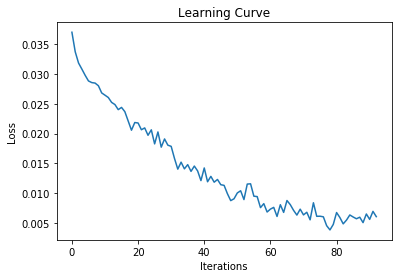

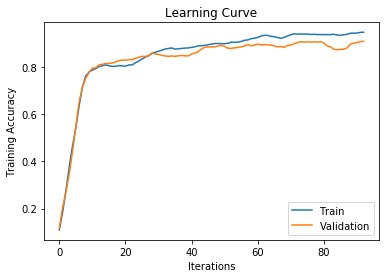

Final Training Accuracy: 0.946
Final Validation Accuracy: 0.908


In [22]:
class MLPBNBeforeReLu(nn.Module):
    def __init__(self, num_hidden):
        super(MLPBNBeforeReLu, self).__init__()
        self.layer1 = nn.Linear(28 * 28, num_hidden)
        self.bn = nn.BatchNorm1d(num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        self.num_hidden = num_hidden
    def forward(self, img):
        flattened = img.view(-1, 28 * 28) # flatten the image
        activation1 = self.layer1(flattened)
        activation1 = self.bn(activation1)
        activation1 = torch.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2
    
train(MLPBNBeforeReLu(30), mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=3)

Batch normalization can be used in CNNs too.

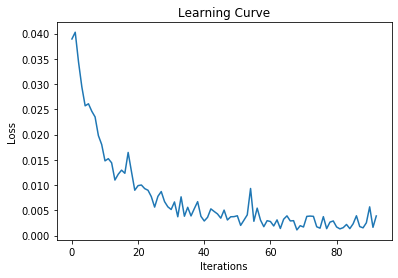

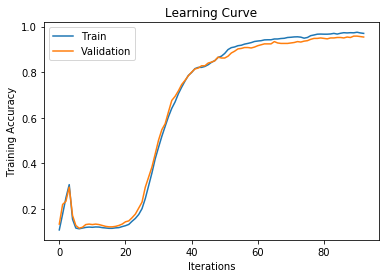

Final Training Accuracy: 0.97
Final Validation Accuracy: 0.954


In [23]:
class CNNBN(nn.Module):
    def __init__(self):
        super(CNNBN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=4,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(4) # num out channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=4,
                               out_channels=8,
                               kernel_size=3,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(8) # num out channels
        self.fc = nn.Linear(8 * 7 * 7, 10)
    def forward(self, x):
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(torch.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(-1, 8 * 7 * 7)
        return self.fc(x)

train(CNNBN(), mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=3)

## Weight Initialization

If we initialize weights to zeros, our neural network will be stuck in a
saddle point. Since we are using stochastic gradient descent, we will see
only noise in the training curve and no progress.

In [ ]:
model = MLP(30)
for p in model.parameters():
    nn.init.zeros_(p)
train(model, mnist_train, optimizer="adam", learning_rate=0.005, num_epochs=3)